# Block 4: Pseudoinverse, Least-Squares & Conditioning

## ML Foundations — Phase 0, Module 1, Block 4

---

## Overview

The **pseudoinverse** and **least-squares** problem lie at the heart of machine learning. Every linear regression, every PCA computation, and every gradient-based optimization involves solving systems that may be overdetermined, underdetermined, or ill-conditioned. Understanding how to solve these problems **stably** is critical for reliable ML.

### Why This Matters for ML

| Problem | Connection to Pseudoinverse/Conditioning |
|---------|------------------------------------------|
| **Linear Regression** | Least-squares solution $\hat{\beta} = (X^T X)^{-1} X^T y$ |
| **Ridge Regression** | Regularized pseudoinverse for ill-conditioning |
| **PCA** | SVD-based, sensitive to small singular values |
| **Neural Network Training** | Hessian conditioning affects optimization |
| **Feature Engineering** | Collinear features → ill-conditioned design matrix |
| **Numerical Stability** | Condition number predicts output sensitivity |

### Block Objectives

By the end of this notebook, you will:

1. **Understand** the geometry of least-squares: projection onto column space
2. **Derive** the Moore–Penrose pseudoinverse from SVD
3. **Prove** that $A^+ b$ gives the minimum-norm least-squares solution
4. **Quantify** conditioning via $\kappa(A) = \sigma_{\max}/\sigma_{\min}$
5. **Implement** three solvers: SVD, Normal Equations, QR
6. **Demonstrate** when each method fails under ill-conditioning
7. **Apply** insights to ML problems (regression, collinearity, optimization)

---

## Table of Contents

1. [Title & Overview](#Block-4:-Pseudoinverse,-Least-Squares-&-Conditioning)
2. [Least-Squares Problem Setup](#Section-2:-Least-Squares-Problem-Setup)
3. [Moore–Penrose Pseudoinverse from SVD](#Section-3:-Moore–Penrose-Pseudoinverse-from-SVD)
4. [Conditioning & Sensitivity](#Section-4:-Conditioning-&-Sensitivity)
5. [Normal Equations vs SVD Solve](#Section-5:-Normal-Equations-vs-SVD-Solve)
6. [QR Factorization Solve](#Section-6:-QR-Factorization-Solve)
7. [Coding: Three Solvers](#Section-7:-Coding-Three-Solvers)
8. [Ill-Conditioned Experiments](#Section-8:-Ill-Conditioned-Experiments)
9. [Practical ML Context](#Section-9:-Practical-ML-Context)
10. [Decision Flowchart](#Section-10:-Decision-Flowchart)
11. [Final Summary](#Section-11:-Final-Summary)

---

## Prerequisites

- **Block 2:** Eigenvalues, spectral theorem
- **Block 3:** SVD, low-rank approximation, singular values
- **Python:** NumPy, Matplotlib

In [1]:
# ============================================================
# SETUP: Import Libraries
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
from time import time

# Plotting configuration
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

# NumPy print options
np.set_printoptions(precision=8, suppress=True)

print("Libraries loaded successfully!")
print(f"NumPy version: {np.__version__}")

Libraries loaded successfully!
NumPy version: 2.3.5


---

# Section 2: Least-Squares Problem Setup

## 2.1 The Overdetermined System

In many ML problems, we have more equations than unknowns:

$$Ax = b$$

where $A \in \mathbb{R}^{m \times n}$ with $m > n$ (tall matrix), $x \in \mathbb{R}^n$, and $b \in \mathbb{R}^m$.

**Example:** Linear regression with $m$ samples and $n$ features:
- $A$ = design matrix (samples × features)
- $x$ = coefficient vector
- $b$ = target values

When $m > n$, there's generally **no exact solution** — we can't pass a line through all points.

---

## 2.2 Residual Minimization

Instead of solving exactly, we minimize the **residual**:

$$\min_x \|Ax - b\|_2^2 = \min_x \sum_{i=1}^m (a_i^T x - b_i)^2$$

This is the **ordinary least-squares (OLS)** problem.

**Why squared norm?**
1. Differentiable (enables calculus-based solutions)
2. Penalizes large errors more than small ones
3. Maximum likelihood under Gaussian noise assumption

---

## 2.3 Geometric Interpretation

The least-squares solution has a beautiful geometric meaning:

**Key Insight:** $\hat{x}$ minimizes $\|Ax - b\|$ when $A\hat{x}$ is the **orthogonal projection** of $b$ onto the column space of $A$.

$$\hat{b} = A\hat{x} = \text{proj}_{\text{col}(A)}(b)$$

**Residual is orthogonal:** $r = b - A\hat{x} \perp \text{col}(A)$

This means $A^T r = 0$, which leads to the **normal equations**:
$$A^T(b - A\hat{x}) = 0 \implies A^T A \hat{x} = A^T b$$

---

## 2.4 When Does a Unique Solution Exist?

| Condition | Consequence |
|-----------|-------------|
| $\text{rank}(A) = n$ (full column rank) | Unique least-squares solution |
| $\text{rank}(A) < n$ | Infinitely many solutions; choose minimum-norm |
| $A^T A$ invertible | Can use normal equations directly |
| $A^T A$ singular | Need pseudoinverse or regularization |

**Key insight:** The solution depends on the **rank** and **conditioning** of $A$, not just its shape.

---

## 2.5 The Projection Matrix

When $A$ has full column rank, the projection onto $\text{col}(A)$ is:

$$P = A(A^T A)^{-1} A^T$$

**Properties:**
- $P^2 = P$ (idempotent)
- $P^T = P$ (symmetric)
- $Pb = A\hat{x}$ (projects $b$ onto column space)
- $I - P$ projects onto the orthogonal complement (null space of $A^T$)

Exercise 2.1: Geometric Least-Squares

Design matrix A:
[[1. 1.]
 [2. 1.]
 [3. 1.]]

Target vector b: [2.  3.  3.5]

Least-squares solution [slope, intercept]: [0.75       1.33333333]

Projection Â x̂ = [2.08333333 2.83333333 3.58333333]
Residual r = b - Ax̂ = [-0.08333333  0.16666667 -0.08333333]
Residual norm: 0.204124

Orthogonality check (A^T r ≈ 0): [-0. -0.]


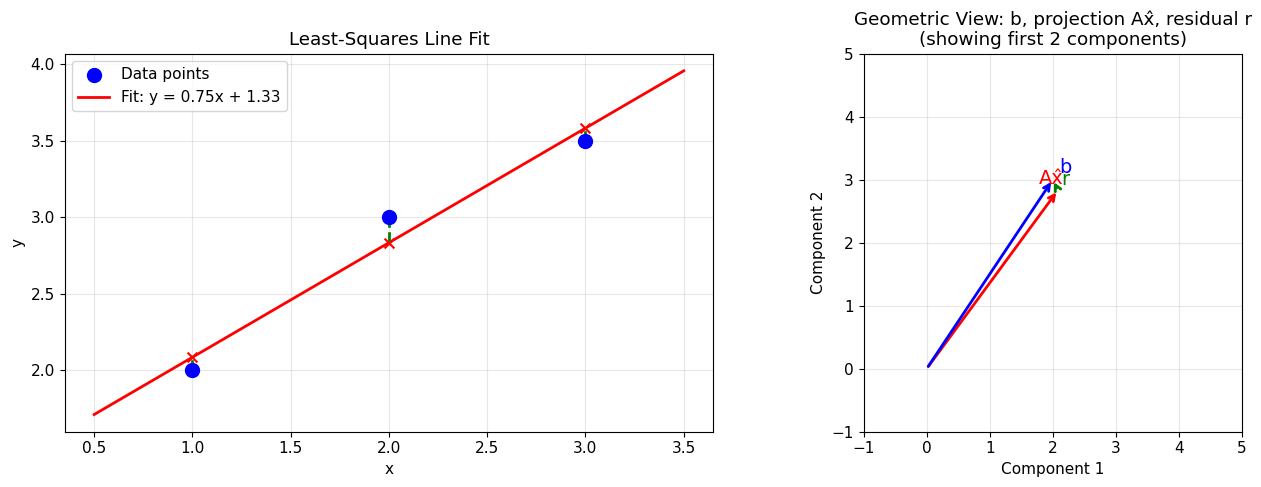


✓ The residual r is orthogonal to the column space of A
✓ This is the geometric essence of least-squares!


In [2]:
# ============================================================
# EXERCISE 2.1: Geometric Least-Squares Visualization
# ============================================================

np.random.seed(42)

# Simple 2D example: fit a line through 3 points
# Model: y = ax + b, or [x, 1] @ [a, b]^T = y

# Three points that don't lie on a line
points = np.array([[1, 2], [2, 3], [3, 3.5]])
x_data, y_data = points[:, 0], points[:, 1]

# Design matrix A (with intercept column)
A = np.column_stack([x_data, np.ones(3)])
b = y_data

print("="*60)
print("Exercise 2.1: Geometric Least-Squares")
print("="*60)
print(f"\nDesign matrix A:\n{A}")
print(f"\nTarget vector b: {b}")

# Solve via normal equations
AtA = A.T @ A
Atb = A.T @ b
x_hat = np.linalg.solve(AtA, Atb)
print(f"\nLeast-squares solution [slope, intercept]: {x_hat}")

# Compute projection and residual
b_hat = A @ x_hat  # Projection onto col(A)
residual = b - b_hat

print(f"\nProjection Â x̂ = {b_hat}")
print(f"Residual r = b - Ax̂ = {residual}")
print(f"Residual norm: {np.linalg.norm(residual):.6f}")

# Verify orthogonality: A^T r = 0
At_r = A.T @ residual
print(f"\nOrthogonality check (A^T r ≈ 0): {At_r}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Data and fitted line
ax1 = axes[0]
ax1.scatter(x_data, y_data, s=100, c='blue', label='Data points', zorder=5)
x_line = np.linspace(0.5, 3.5, 100)
y_line = x_hat[0] * x_line + x_hat[1]
ax1.plot(x_line, y_line, 'r-', linewidth=2, label=f'Fit: y = {x_hat[0]:.2f}x + {x_hat[1]:.2f}')

# Show residuals as vertical lines
for i in range(3):
    ax1.plot([x_data[i], x_data[i]], [y_data[i], b_hat[i]], 'g--', linewidth=2)
    ax1.scatter([x_data[i]], [b_hat[i]], s=50, c='red', marker='x', zorder=5)

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_title('Least-Squares Line Fit')
ax1.legend()

# Plot 2: Geometric view in R^3 (b space)
ax2 = axes[1]
ax2.set_xlim(-1, 5)
ax2.set_ylim(-1, 5)

# Show b and its projection
ax2.annotate('', xy=(b_hat[0], b_hat[1]), xytext=(0, 0),
             arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax2.annotate('', xy=(b[0], b[1]), xytext=(0, 0),
             arrowprops=dict(arrowstyle='->', color='blue', lw=2))
ax2.annotate('', xy=(b[0], b[1]), xytext=(b_hat[0], b_hat[1]),
             arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax2.text(b[0]+0.1, b[1]+0.1, 'b', fontsize=14, color='blue')
ax2.text(b_hat[0]-0.3, b_hat[1]+0.1, 'Ax̂', fontsize=14, color='red')
ax2.text((b[0]+b_hat[0])/2+0.1, (b[1]+b_hat[1])/2, 'r', fontsize=14, color='green')

ax2.set_xlabel('Component 1')
ax2.set_ylabel('Component 2')
ax2.set_title('Geometric View: b, projection Ax̂, residual r\n(showing first 2 components)')
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

print("\n✓ The residual r is orthogonal to the column space of A")
print("✓ This is the geometric essence of least-squares!")

---

# Section 3: Moore–Penrose Pseudoinverse from SVD

## 3.1 Motivation

The ordinary inverse $A^{-1}$ only exists for square, non-singular matrices. But we need a generalized inverse that works for:
- Rectangular matrices (overdetermined/underdetermined systems)
- Rank-deficient matrices
- Singular matrices

The **Moore–Penrose pseudoinverse** $A^+$ is this universal solution.

---

## 3.2 Definition via SVD

**Theorem 3.1 (Pseudoinverse via SVD):**

*Let $A \in \mathbb{R}^{m \times n}$ have SVD $A = U \Sigma V^T$ with $r = \text{rank}(A)$ nonzero singular values $\sigma_1 \geq \cdots \geq \sigma_r > 0$. Then the pseudoinverse is:*

$$A^+ = V \Sigma^+ U^T$$

*where $\Sigma^+ \in \mathbb{R}^{n \times m}$ has diagonal entries:*

$$(\Sigma^+)_{ii} = \begin{cases} 1/\sigma_i & i \leq r \\ 0 & i > r \end{cases}$$

**Explicit formula:**

$$A^+ = \sum_{i=1}^r \frac{1}{\sigma_i} v_i u_i^T$$

---

## 3.3 Cases by Matrix Shape

### Case 1: Tall matrix ($m > n$), full column rank

$$A^+ = (A^T A)^{-1} A^T$$

This gives the **least-squares** solution: $x = A^+ b$ minimizes $\|Ax - b\|$.

### Case 2: Wide matrix ($m < n$), full row rank

$$A^+ = A^T (A A^T)^{-1}$$

This gives the **minimum-norm** solution among all exact solutions.

### Case 3: Rank-deficient matrix

Use SVD: $A^+ = V \Sigma^+ U^T$. This gives the **minimum-norm least-squares** solution.

---

## 3.4 The Four Moore–Penrose Conditions

**Definition 3.2:** The pseudoinverse $A^+$ is the unique matrix satisfying:

1. $A A^+ A = A$ (generalized inverse)
2. $A^+ A A^+ = A^+$ (reflexive)
3. $(A A^+)^T = A A^+$ (hermitian projection onto col(A))
4. $(A^+ A)^T = A^+ A$ (hermitian projection onto row(A))

**Proof that SVD formula satisfies these:**

Let $A = U\Sigma V^T$ and $A^+ = V\Sigma^+ U^T$.

**(1)** $A A^+ A = U\Sigma V^T \cdot V\Sigma^+ U^T \cdot U\Sigma V^T = U\Sigma\Sigma^+\Sigma V^T = U\Sigma V^T = A$ ✓

**(2)** $A^+ A A^+ = V\Sigma^+ U^T \cdot U\Sigma V^T \cdot V\Sigma^+ U^T = V\Sigma^+\Sigma\Sigma^+ U^T = V\Sigma^+ U^T = A^+$ ✓

**(3)** $(AA^+)^T = (U\Sigma\Sigma^+ U^T)^T = U\Sigma\Sigma^+ U^T = AA^+$ ✓ (since $\Sigma\Sigma^+$ is diagonal)

**(4)** $(A^+A)^T = (V\Sigma^+\Sigma V^T)^T = V\Sigma^+\Sigma V^T = A^+A$ ✓

---

## 3.5 Minimum-Norm Least-Squares Solution

**Theorem 3.3 (Fundamental Theorem of Pseudoinverse):**

*The solution $x^+ = A^+ b$ is the unique vector that:*

1. *Minimizes $\|Ax - b\|$ (least-squares)*
2. *Among all minimizers, has minimum $\|x\|$ (minimum-norm)*

**Proof:**

**Part 1 (Least-squares):** Let $\hat{b} = AA^+ b$ be the projection of $b$ onto $\text{col}(A)$.

$A x^+ = A A^+ b = U\Sigma V^T V\Sigma^+ U^T b = U\Sigma\Sigma^+ U^T b$

For $i \leq r$: $(\Sigma\Sigma^+)_{ii} = 1$, so $AA^+$ projects onto the first $r$ columns of $U$ = $\text{col}(A)$.

Thus $Ax^+ = \text{proj}_{\text{col}(A)}(b)$, which minimizes $\|Ax - b\|$.

**Part 2 (Minimum-norm):** Any solution can be written as $x = x^+ + z$ where $z \in \text{null}(A)$.

$\|x\|^2 = \|x^+ + z\|^2 = \|x^+\|^2 + 2\langle x^+, z \rangle + \|z\|^2$

Now $x^+ = V\Sigma^+ U^T b = \sum_{i=1}^r \frac{u_i^T b}{\sigma_i} v_i$ lies in $\text{row}(A) = \text{span}\{v_1, \ldots, v_r\}$.

Since $z \in \text{null}(A) = \text{span}\{v_{r+1}, \ldots, v_n\}$ and these are orthogonal:

$\langle x^+, z \rangle = 0$

Therefore $\|x\|^2 = \|x^+\|^2 + \|z\|^2 \geq \|x^+\|^2$, with equality iff $z = 0$. $\square$

In [3]:
# ============================================================
# EXERCISE 3.1: Verify Moore-Penrose Conditions
# ============================================================

np.random.seed(42)

print("="*70)
print("Exercise 3.1: Verify Moore-Penrose Conditions")
print("="*70)

# Test on various matrix types
test_cases = {
    "Tall full-rank (5×3)": np.random.randn(5, 3),
    "Wide full-rank (3×5)": np.random.randn(3, 5),
    "Rank-deficient (5×4, rank 2)": np.random.randn(5, 2) @ np.random.randn(2, 4),
    "Square singular (4×4)": np.column_stack([np.random.randn(4, 2), np.random.randn(4, 2) @ [[1, 0], [0, 0]]])
}

for name, A in test_cases.items():
    print(f"\n{'-'*50}")
    print(f"Case: {name}")
    print(f"Shape: {A.shape}, Rank: {np.linalg.matrix_rank(A)}")
    
    # Compute pseudoinverse via NumPy
    A_pinv = np.linalg.pinv(A)
    
    # Verify four Moore-Penrose conditions
    cond1 = np.linalg.norm(A @ A_pinv @ A - A)
    cond2 = np.linalg.norm(A_pinv @ A @ A_pinv - A_pinv)
    cond3 = np.linalg.norm((A @ A_pinv).T - A @ A_pinv)
    cond4 = np.linalg.norm((A_pinv @ A).T - A_pinv @ A)
    
    print(f"  (1) ||AA⁺A - A|| = {cond1:.2e}")
    print(f"  (2) ||A⁺AA⁺ - A⁺|| = {cond2:.2e}")
    print(f"  (3) ||(AA⁺)ᵀ - AA⁺|| = {cond3:.2e}")
    print(f"  (4) ||(A⁺A)ᵀ - A⁺A|| = {cond4:.2e}")
    
    all_pass = all(c < 1e-10 for c in [cond1, cond2, cond3, cond4])
    print(f"  All conditions satisfied: {'✓' if all_pass else '✗'}")

print("\n" + "="*70)
print("✓ Moore-Penrose conditions verified for all matrix types!")
print("="*70)

Exercise 3.1: Verify Moore-Penrose Conditions

--------------------------------------------------
Case: Tall full-rank (5×3)
Shape: (5, 3), Rank: 3
  (1) ||AA⁺A - A|| = 1.99e-15
  (2) ||A⁺AA⁺ - A⁺|| = 7.57e-16
  (3) ||(AA⁺)ᵀ - AA⁺|| = 8.47e-16
  (4) ||(A⁺A)ᵀ - A⁺A|| = 1.45e-15
  All conditions satisfied: ✓

--------------------------------------------------
Case: Wide full-rank (3×5)
Shape: (3, 5), Rank: 3
  (1) ||AA⁺A - A|| = 8.01e-16
  (2) ||A⁺AA⁺ - A⁺|| = 2.03e-16
  (3) ||(AA⁺)ᵀ - AA⁺|| = 2.79e-16
  (4) ||(A⁺A)ᵀ - A⁺A|| = 6.04e-16
  All conditions satisfied: ✓

--------------------------------------------------
Case: Rank-deficient (5×4, rank 2)
Shape: (5, 4), Rank: 2
  (1) ||AA⁺A - A|| = 2.42e-15
  (2) ||A⁺AA⁺ - A⁺|| = 3.95e-16
  (3) ||(AA⁺)ᵀ - AA⁺|| = 4.51e-15
  (4) ||(A⁺A)ᵀ - A⁺A|| = 6.57e-16
  All conditions satisfied: ✓

--------------------------------------------------
Case: Square singular (4×4)
Shape: (4, 4), Rank: 3
  (1) ||AA⁺A - A|| = 1.15e-15
  (2) ||A⁺AA⁺ - A⁺|| = 5.83

In [4]:
# ============================================================
# EXERCISE 3.2: Pseudoinverse from SVD — From Scratch
# ============================================================

def pinv_via_svd(A, tol=None):
    """
    Compute Moore-Penrose pseudoinverse via SVD.
    
    A⁺ = V Σ⁺ Uᵀ where Σ⁺ᵢᵢ = 1/σᵢ for σᵢ > tol, else 0
    
    Parameters:
        A: array of shape (m, n)
        tol: threshold for treating singular values as zero
             Default: max(m,n) * max(σ) * machine_epsilon
    
    Returns:
        A_pinv: array of shape (n, m)
    """
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    
    # Determine tolerance for numerical rank
    if tol is None:
        tol = max(A.shape) * s[0] * np.finfo(A.dtype).eps
    
    # Compute reciprocals for non-tiny singular values
    s_inv = np.zeros_like(s)
    for i, sigma in enumerate(s):
        if sigma > tol:
            s_inv[i] = 1.0 / sigma
    
    # A⁺ = V Σ⁺ Uᵀ
    # Since we have Vt (V transposed), we need V = Vt.T
    # A⁺ = Vt.T @ diag(s_inv) @ U.T
    return (Vt.T * s_inv) @ U.T

print("="*70)
print("Exercise 3.2: Pseudoinverse from SVD — From Scratch")
print("="*70)

# Test our implementation
np.random.seed(42)
test_matrices = [
    ("Full-rank tall", np.random.randn(6, 4)),
    ("Full-rank wide", np.random.randn(4, 6)),
    ("Rank-deficient", np.random.randn(5, 2) @ np.random.randn(2, 5)),
]

for name, A in test_matrices:
    our_pinv = pinv_via_svd(A)
    numpy_pinv = np.linalg.pinv(A)
    
    error = np.linalg.norm(our_pinv - numpy_pinv) / np.linalg.norm(numpy_pinv)
    
    print(f"\n{name} {A.shape}:")
    print(f"  Rank: {np.linalg.matrix_rank(A)}")
    print(f"  ||A⁺_ours - A⁺_numpy|| / ||A⁺_numpy|| = {error:.2e}")
    print(f"  Match: {'✓' if error < 1e-12 else '✗'}")

print("\n" + "="*70)
print("✓ Our SVD-based pseudoinverse matches NumPy!")
print("="*70)

Exercise 3.2: Pseudoinverse from SVD — From Scratch

Full-rank tall (6, 4):
  Rank: 4
  ||A⁺_ours - A⁺_numpy|| / ||A⁺_numpy|| = 5.38e-17
  Match: ✓

Full-rank wide (4, 6):
  Rank: 4
  ||A⁺_ours - A⁺_numpy|| / ||A⁺_numpy|| = 1.21e-16
  Match: ✓

Rank-deficient (5, 5):
  Rank: 2
  ||A⁺_ours - A⁺_numpy|| / ||A⁺_numpy|| = 5.80e-17
  Match: ✓

✓ Our SVD-based pseudoinverse matches NumPy!


Exercise 3.3: Minimum-Norm Solution Property
System: A ∈ ℝ^(3×6), b ∈ ℝ³
Underdetermined: infinitely many solutions exist

Pseudoinverse solution x⁺ = A⁺b:
  ||x⁺||₂ = 0.861506
  Residual ||Ax⁺ - b||₂ = 1.16e-15

--------------------------------------------------
Generating 1000 random solutions of the form x = x⁺ + z
where z is in the null space of A
Null space dimension: 3

Results:
  ||x⁺||₂ (pseudoinverse) = 0.861506
  min ||x||₂ (random)     = 0.870794
  max ||x||₂ (random)     = 16.187570
  x⁺ is minimum-norm: ✓


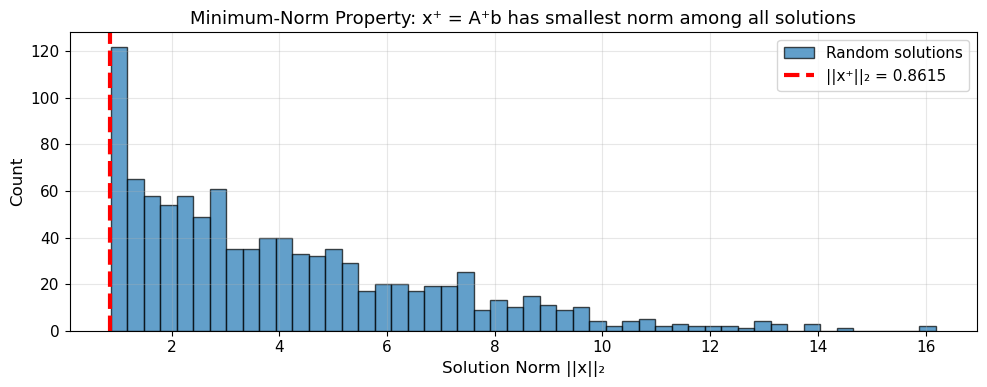


✓ Verified: Pseudoinverse gives minimum-norm solution!


In [5]:
# ============================================================
# EXERCISE 3.3: Minimum-Norm Property Demonstration
# ============================================================

print("="*70)
print("Exercise 3.3: Minimum-Norm Solution Property")
print("="*70)

# Create an underdetermined system (infinitely many solutions)
np.random.seed(42)
A = np.random.randn(3, 6)  # 3 equations, 6 unknowns
b = np.random.randn(3)

# The pseudoinverse solution
x_pinv = np.linalg.pinv(A) @ b

print(f"System: A ∈ ℝ^(3×6), b ∈ ℝ³")
print(f"Underdetermined: infinitely many solutions exist")
print(f"\nPseudoinverse solution x⁺ = A⁺b:")
print(f"  ||x⁺||₂ = {np.linalg.norm(x_pinv):.6f}")
print(f"  Residual ||Ax⁺ - b||₂ = {np.linalg.norm(A @ x_pinv - b):.2e}")

# Generate many other solutions: x = x_pinv + null space component
print(f"\n{'-'*50}")
print("Generating 1000 random solutions of the form x = x⁺ + z")
print("where z is in the null space of A")

# Compute null space basis
_, s, Vt = np.linalg.svd(A, full_matrices=True)
rank = np.sum(s > 1e-10)
null_basis = Vt[rank:].T  # Columns span null space

print(f"Null space dimension: {null_basis.shape[1]}")

norms = []
for _ in range(1000):
    # Random null space component
    coeffs = np.random.randn(null_basis.shape[1]) * np.random.uniform(0.1, 5)
    z = null_basis @ coeffs
    x_other = x_pinv + z
    
    # Verify it's still a solution
    residual = np.linalg.norm(A @ x_other - b)
    assert residual < 1e-10, "Should still solve Ax = b"
    
    norms.append(np.linalg.norm(x_other))

print(f"\nResults:")
print(f"  ||x⁺||₂ (pseudoinverse) = {np.linalg.norm(x_pinv):.6f}")
print(f"  min ||x||₂ (random)     = {min(norms):.6f}")
print(f"  max ||x||₂ (random)     = {max(norms):.6f}")
print(f"  x⁺ is minimum-norm: {'✓' if np.linalg.norm(x_pinv) <= min(norms) + 1e-10 else '✗'}")

# Visualize
fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(norms, bins=50, alpha=0.7, edgecolor='black', label='Random solutions')
ax.axvline(np.linalg.norm(x_pinv), color='red', linewidth=3, 
           linestyle='--', label=f'||x⁺||₂ = {np.linalg.norm(x_pinv):.4f}')
ax.set_xlabel('Solution Norm ||x||₂', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Minimum-Norm Property: x⁺ = A⁺b has smallest norm among all solutions', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✓ Verified: Pseudoinverse gives minimum-norm solution!")
print("="*70)

---

## 4. Conditioning & Sensitivity Analysis

### 4.1 The Condition Number

**Definition (Condition Number):**
For a matrix $A$ with positive singular values, the **condition number** is:

$$\kappa(A) = \frac{\sigma_{\max}(A)}{\sigma_{\min}(A)} = \|A\| \cdot \|A^{-1}\|$$

For the 2-norm, this is exactly $\sigma_1 / \sigma_r$ where $r = \text{rank}(A)$.

---

### 4.2 Sensitivity Interpretation

**The Fundamental Question:** If we perturb the data slightly, how much does the solution change?

**Theorem (Least-Squares Perturbation Bound):**
Let $\hat{x}$ solve $\min_x \|Ax - b\|_2$ and let $\hat{x} + \delta x$ solve the perturbed problem with $A + \delta A$ and $b + \delta b$. Then:

$$\frac{\|\delta x\|}{\|\hat{x}\|} \leq \kappa(A) \left( \frac{\|\delta A\|}{\|A\|} + \frac{\|\delta b\|}{\|b\|} \right) + \kappa(A)^2 \frac{\|\delta A\|}{\|A\|} \cdot \text{(residual terms)}$$

**Key Insight:**
- **Well-conditioned** ($\kappa(A) \approx 1$): Small perturbations → Small changes in solution
- **Ill-conditioned** ($\kappa(A) \gg 1$): Small perturbations → Potentially huge changes

---

### 4.3 Geometric Interpretation

Consider solving $Ax = b$ where $A$ has singular values $\sigma_1, \sigma_2$:

$$x = A^+ b = \sum_{i=1}^r \frac{1}{\sigma_i} \langle u_i, b \rangle v_i$$

- Components along small $\sigma_i$ directions get **amplified** by $1/\sigma_i$
- If $\sigma_{\min}$ is tiny, noise in those directions explodes

**Visual Intuition:**
- Well-conditioned: $A$ maps a circle to a circle-ish ellipse (mild distortion)
- Ill-conditioned: $A$ maps a circle to a very thin ellipse (extreme distortion)
- Inverting: thin ellipse → huge amplification along the squeezed direction

---

### 4.4 Why This Matters for ML

| Situation | Effect | Symptoms |
|-----------|--------|----------|
| $\kappa(X^T X) \gg 1$ (multicollinearity) | Coefficients unstable | Removing one feature changes all coefficients drastically |
| Near-singular Hessian | Ill-conditioned optimization | Slow convergence, zigzagging |
| Large condition number | Numerical errors dominate | Different runs give different results |

**Rule of Thumb:** 
- $\kappa(A) > 10^{12}$ → You're losing ~12 digits of precision
- For float64 (16 digits), this leaves ~4 significant digits!

Exercise 4.1: Geometric Visualization of Conditioning


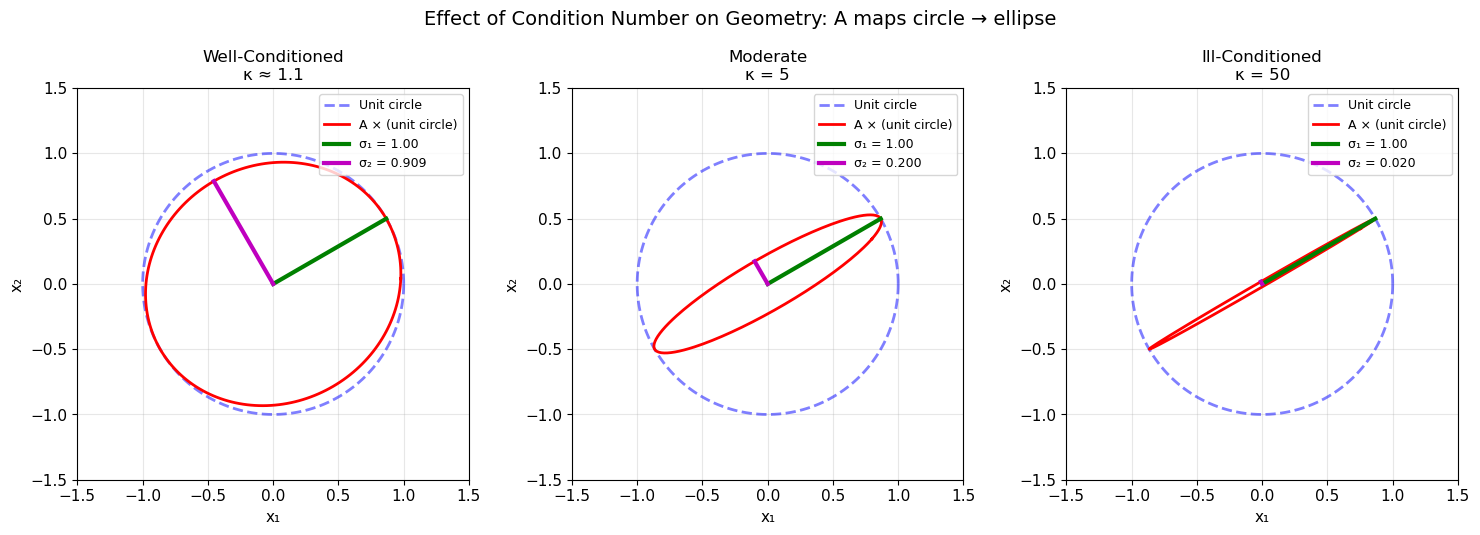


Observation: As κ increases, the ellipse becomes thinner.
Inverting a thin ellipse amplifies errors in the squeezed direction.


In [6]:
# ============================================================
# EXERCISE 4.1: Geometric Visualization of Conditioning
# ============================================================

print("="*70)
print("Exercise 4.1: Geometric Visualization of Conditioning")
print("="*70)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Unit circle
theta = np.linspace(0, 2*np.pi, 200)
circle = np.vstack([np.cos(theta), np.sin(theta)])

condition_numbers = [1.1, 5, 50]
titles = ['Well-Conditioned\nκ ≈ 1.1', 'Moderate\nκ = 5', 'Ill-Conditioned\nκ = 50']

for ax, kappa, title in zip(axes, condition_numbers, titles):
    # Create matrix with specified condition number
    # A = U @ diag(sigma) @ V.T with sigma = [1, 1/kappa]
    angle = np.pi/6
    U = np.array([[np.cos(angle), -np.sin(angle)], 
                  [np.sin(angle), np.cos(angle)]])
    sigma = np.array([1, 1/kappa])
    A = U @ np.diag(sigma) @ U.T
    
    # Transform circle -> ellipse
    ellipse = A @ circle
    
    # Plot
    ax.plot(circle[0], circle[1], 'b--', linewidth=2, alpha=0.5, label='Unit circle')
    ax.plot(ellipse[0], ellipse[1], 'r-', linewidth=2, label=f'A × (unit circle)')
    
    # Mark axes
    ax.plot([0, U[0,0]*sigma[0]], [0, U[1,0]*sigma[0]], 'g-', linewidth=3, 
            label=f'σ₁ = {sigma[0]:.2f}')
    ax.plot([0, U[0,1]*sigma[1]], [0, U[1,1]*sigma[1]], 'm-', linewidth=3,
            label=f'σ₂ = {sigma[1]:.3f}')
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-1.5, 1.5)
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='upper right')
    ax.set_title(title, fontsize=12)
    ax.set_xlabel('x₁', fontsize=11)
    ax.set_ylabel('x₂', fontsize=11)

plt.suptitle('Effect of Condition Number on Geometry: A maps circle → ellipse', 
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print("\nObservation: As κ increases, the ellipse becomes thinner.")
print("Inverting a thin ellipse amplifies errors in the squeezed direction.")

Exercise 4.2: Error Amplification by Condition Number


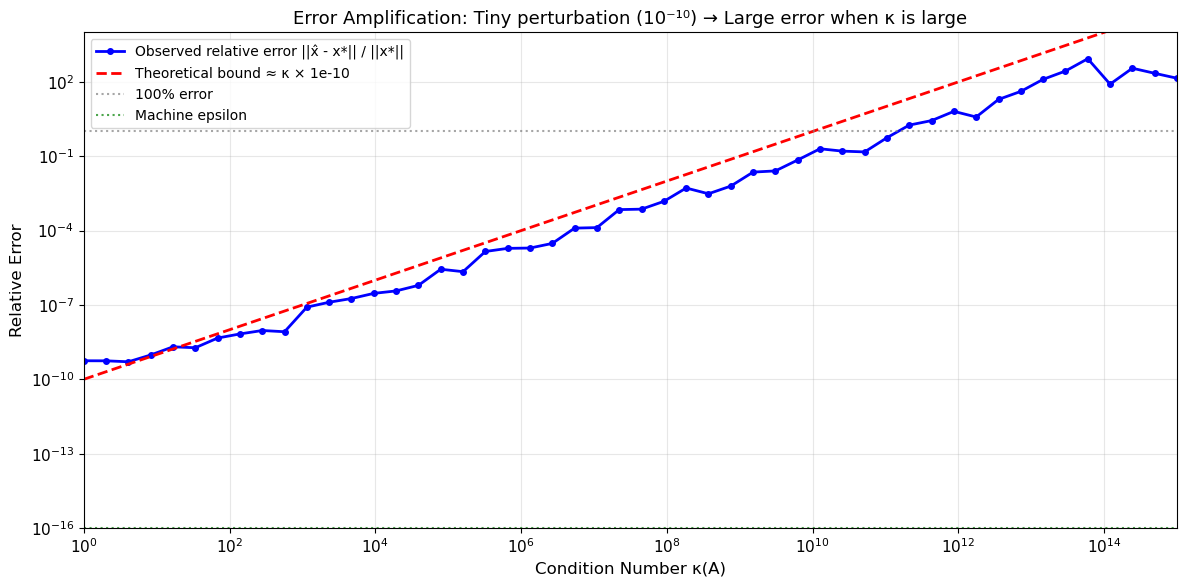


--------------------------------------------------
Key Insight:
  Input perturbation: 1e-10
  At κ = 10⁰:  Error ≈ 5.61e-10
  At κ = 10⁸:  Error ≈ 7.34e-04
  At κ = 10¹⁵: Error ≈ 1.41e+02

→ Solution error ≈ κ × data error (first-order approximation)


In [7]:
# ============================================================
# EXERCISE 4.2: Error Amplification Experiment
# ============================================================

print("="*70)
print("Exercise 4.2: Error Amplification by Condition Number")
print("="*70)

np.random.seed(42)

def create_matrix_with_condition(m, n, kappa):
    """Create m×n matrix with specified condition number."""
    U, _ = np.linalg.qr(np.random.randn(m, m))
    V, _ = np.linalg.qr(np.random.randn(n, n))
    
    rank = min(m, n)
    # Singular values: geometric progression from 1 to 1/kappa
    sigma = np.logspace(0, -np.log10(kappa), rank)
    
    S = np.zeros((m, n))
    S[:rank, :rank] = np.diag(sigma)
    
    return U @ S @ V.T

# Test various condition numbers
condition_numbers = np.logspace(0, 15, 50)  # 1 to 10^15
m, n = 50, 30

# Storage
relative_errors = []

for kappa in condition_numbers:
    A = create_matrix_with_condition(m, n, kappa)
    
    # True solution
    x_true = np.random.randn(n)
    b_exact = A @ x_true
    
    # Perturbed problem (small noise in b)
    noise_level = 1e-10
    b_noisy = b_exact + noise_level * np.linalg.norm(b_exact) * np.random.randn(m)
    
    # Solve perturbed problem
    x_computed = np.linalg.lstsq(A, b_noisy, rcond=None)[0]
    
    # Relative error
    rel_err = np.linalg.norm(x_computed - x_true) / np.linalg.norm(x_true)
    relative_errors.append(rel_err)

# Theoretical bound: error ≈ κ × (perturbation)
theoretical_bound = condition_numbers * noise_level

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
ax.loglog(condition_numbers, relative_errors, 'b-', linewidth=2, 
          label='Observed relative error ||x̂ - x*|| / ||x*||', marker='o', markersize=4)
ax.loglog(condition_numbers, theoretical_bound, 'r--', linewidth=2,
          label=f'Theoretical bound ≈ κ × {noise_level:.0e}')

# Reference lines
ax.axhline(1.0, color='gray', linestyle=':', alpha=0.7, label='100% error')
ax.axhline(1e-16, color='green', linestyle=':', alpha=0.7, label='Machine epsilon')

ax.set_xlabel('Condition Number κ(A)', fontsize=12)
ax.set_ylabel('Relative Error', fontsize=12)
ax.set_title('Error Amplification: Tiny perturbation (10⁻¹⁰) → Large error when κ is large', 
             fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, which='both', alpha=0.3)
ax.set_xlim(1, 1e15)
ax.set_ylim(1e-16, 1e4)

plt.tight_layout()
plt.show()

print("\n" + "-"*50)
print("Key Insight:")
print(f"  Input perturbation: {noise_level:.0e}")
print(f"  At κ = 10⁰:  Error ≈ {relative_errors[0]:.2e}")
print(f"  At κ = 10⁸:  Error ≈ {relative_errors[25]:.2e}")
print(f"  At κ = 10¹⁵: Error ≈ {relative_errors[-1]:.2e}")
print("\n→ Solution error ≈ κ × data error (first-order approximation)")

---

## 5. The Normal Equations Method

### 5.1 Derivation

The least-squares problem $\min_x \|Ax - b\|_2^2$ has gradient:

$$\nabla_x \|Ax - b\|_2^2 = 2A^T(Ax - b)$$

Setting gradient to zero:
$$A^T A x = A^T b$$

These are the **normal equations**. If $A$ has full column rank, then $A^T A$ is positive definite (thus invertible), giving:

$$\hat{x} = (A^T A)^{-1} A^T b$$

---

### 5.2 The Condition Number Problem

**Critical Issue:**
$$\kappa(A^T A) = \kappa(A)^2$$

**Proof:**
If $A = U\Sigma V^T$ (SVD), then:
$$A^T A = V \Sigma^T \Sigma V^T = V \text{diag}(\sigma_1^2, \ldots, \sigma_n^2) V^T$$

So:
$$\kappa(A^T A) = \frac{\sigma_1^2}{\sigma_n^2} = \left(\frac{\sigma_1}{\sigma_n}\right)^2 = \kappa(A)^2$$

**Consequences:**
| $\kappa(A)$ | $\kappa(A^T A)$ | Digits Lost |
|-------------|-----------------|-------------|
| $10^4$ | $10^8$ | ~8 digits |
| $10^6$ | $10^{12}$ | ~12 digits |
| $10^8$ | $10^{16}$ | All precision lost! |

---

### 5.3 When Normal Equations Work Fine

Despite the condition number issue, normal equations are often used because:

1. **Small, well-conditioned problems**: If $\kappa(A) < 10^6$, squaring still fits in float64
2. **Dense systems**: Cholesky factorization of $A^T A$ is fast ($\frac{1}{3}n^3$ flops)
3. **Symmetric positive definite**: Can use efficient Cholesky instead of general LU

**Algorithm (Normal Equations via Cholesky):**
```
1. Form G = AᵀA           # O(mn²)
2. Form c = Aᵀb           # O(mn)
3. Cholesky: G = LLᵀ      # O(n³/3)
4. Solve Ly = c           # O(n²)
5. Solve Lᵀx = y          # O(n²)
```

Total: $O(mn^2 + n^3/3)$ — often faster than SVD's $O(mn^2 + n^3)$

In [8]:
# ============================================================
# EXERCISE 5.1: Normal Equations — From Scratch
# ============================================================

def solve_normal_equations(A, b):
    """
    Solve least-squares via normal equations with Cholesky.
    
    Solves: AᵀAx = Aᵀb using Cholesky factorization.
    
    Parameters:
        A: array of shape (m, n) with m >= n and full column rank
        b: array of shape (m,)
    
    Returns:
        x: least-squares solution of shape (n,)
    """
    # Form normal equations
    ATA = A.T @ A
    ATb = A.T @ b
    
    # Cholesky factorization: AᵀA = LLᵀ
    L = np.linalg.cholesky(ATA)
    
    # Solve Ly = Aᵀb (forward substitution)
    y = np.linalg.solve(L, ATb)
    
    # Solve Lᵀx = y (backward substitution)
    x = np.linalg.solve(L.T, y)
    
    return x

print("="*70)
print("Exercise 5.1: Normal Equations Implementation")
print("="*70)

# Test on well-conditioned system
np.random.seed(42)
m, n = 100, 20
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A @ x_true + 0.01 * np.random.randn(m)  # Small noise

# Solve
x_normal = solve_normal_equations(A, b)
x_lstsq = np.linalg.lstsq(A, b, rcond=None)[0]

print(f"\nSystem: {m}×{n} matrix")
print(f"Condition number κ(A) = {np.linalg.cond(A):.2f}")
print(f"Condition number κ(AᵀA) = {np.linalg.cond(A.T @ A):.2f}")

print(f"\nResults:")
print(f"  ||x_normal - x_lstsq|| = {np.linalg.norm(x_normal - x_lstsq):.2e}")
print(f"  ||x_normal - x_true|| = {np.linalg.norm(x_normal - x_true):.6f}")
print(f"  Residual ||Ax - b|| = {np.linalg.norm(A @ x_normal - b):.6f}")

print("\n" + "="*70)
print("✓ Normal equations work well for well-conditioned systems")
print("="*70)

Exercise 5.1: Normal Equations Implementation

System: 100×20 matrix
Condition number κ(A) = 2.51
Condition number κ(AᵀA) = 6.32

Results:
  ||x_normal - x_lstsq|| = 6.67e-15
  ||x_normal - x_true|| = 0.004803
  Residual ||Ax - b|| = 0.085022

✓ Normal equations work well for well-conditioned systems


Exercise 5.2: Condition Number Squaring Effect

Comparing κ(A) vs κ(AᵀA):
---------------------------------------------
        κ(A) |          κ(AᵀA) |        Ratio
---------------------------------------------
    1.00e+02 |        1.00e+04 |       100.00
    1.00e+04 |        1.00e+08 |     10000.00
    1.00e+06 |        1.00e+12 |    999981.75
    1.00e+08 |        9.92e+15 |  99227923.56
---------------------------------------------

→ Confirmed: κ(AᵀA) = κ(A)²


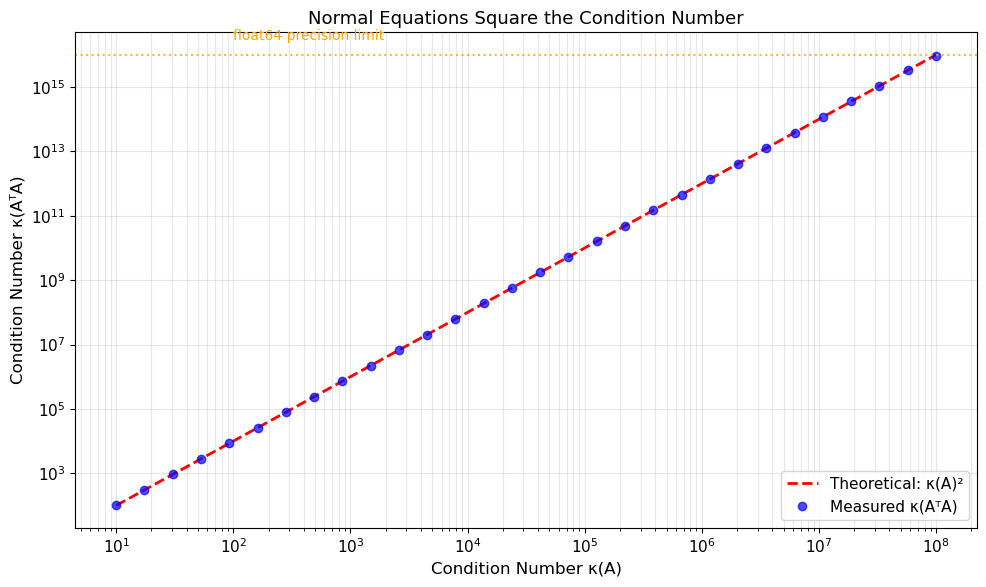


⚠️  When κ(A) > 10⁸, normal equations lose all precision!


In [9]:
# ============================================================
# EXERCISE 5.2: Condition Number Squaring Demonstration
# ============================================================

print("="*70)
print("Exercise 5.2: Condition Number Squaring Effect")
print("="*70)

np.random.seed(42)

condition_numbers = [1e2, 1e4, 1e6, 1e8]
m, n = 50, 20

print(f"\nComparing κ(A) vs κ(AᵀA):")
print("-" * 45)
print(f"{'κ(A)':>12} | {'κ(AᵀA)':>15} | {'Ratio':>12}")
print("-" * 45)

for kappa in condition_numbers:
    A = create_matrix_with_condition(m, n, kappa)
    
    kappa_A = np.linalg.cond(A)
    kappa_ATA = np.linalg.cond(A.T @ A)
    
    print(f"{kappa_A:>12.2e} | {kappa_ATA:>15.2e} | {kappa_ATA/kappa_A:>12.2f}")

print("-" * 45)
print("\n→ Confirmed: κ(AᵀA) = κ(A)²")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))

kappas = np.logspace(1, 8, 30)
kappa_squared = []

for k in kappas:
    A = create_matrix_with_condition(m, n, k)
    kappa_squared.append(np.linalg.cond(A.T @ A))

ax.loglog(kappas, kappas**2, 'r--', linewidth=2, label='Theoretical: κ(A)²')
ax.loglog(kappas, kappa_squared, 'bo', markersize=6, alpha=0.7, label='Measured κ(AᵀA)')

ax.set_xlabel('Condition Number κ(A)', fontsize=12)
ax.set_ylabel('Condition Number κ(AᵀA)', fontsize=12)
ax.set_title('Normal Equations Square the Condition Number', fontsize=13)
ax.legend(fontsize=11)
ax.grid(True, which='both', alpha=0.3)

# Danger zone
ax.axhline(1e16, color='orange', linestyle=':', alpha=0.8)
ax.text(1e2, 3e16, 'float64 precision limit', fontsize=10, color='orange')

plt.tight_layout()
plt.show()

print("\n⚠️  When κ(A) > 10⁸, normal equations lose all precision!")

---

## 6. QR Factorization Method

### 6.1 The QR Approach

For $A = QR$ where $Q \in \mathbb{R}^{m \times n}$ has orthonormal columns and $R \in \mathbb{R}^{n \times n}$ is upper triangular:

$$\|Ax - b\|^2 = \|QRx - b\|^2 = \|Rx - Q^T b\|^2$$

(since $\|Q^T v\|^2 = \|v\|^2$ for orthogonal $Q$)

Let $c = Q^T b$. The minimum is achieved when:
$$Rx = c$$

This is an upper triangular system — solve by **back substitution**!

---

### 6.2 Why QR is Numerically Superior

**Key Property:** QR avoids forming $A^T A$.

The condition number of $R$ equals $\kappa(A)$ (not $\kappa(A)^2$!).

**Proof sketch:**
Since $A = QR$ and $Q$ has orthonormal columns:
$$\kappa(A) = \kappa(QR) = \kappa(R)$$
(orthogonal transformations preserve singular values)

**Stability Comparison:**
| Method | Effective Condition Number | Back-Stability |
|--------|---------------------------|----------------|
| Normal Equations | $\kappa(A)^2$ | Unstable for ill-conditioned |
| QR Factorization | $\kappa(A)$ | Backward stable |
| SVD | $\kappa(A)$ | Most robust |

---

### 6.3 Algorithm

**QR Least-Squares Algorithm:**
```
1. QR factorization: A = QR    # O(2mn² - 2n³/3) via Householder
2. Compute c = Qᵀb            # O(mn)
3. Back-solve Rx = c          # O(n²)
```

**Advantages:**
- No squaring of condition number
- Faster than SVD (no full singular value decomposition)
- Numerically stable (especially with Householder reflections)

**Disadvantage:**
- Requires $A$ to have full column rank (else $R$ is singular)

In [10]:
# ============================================================
# EXERCISE 6.1: QR Least-Squares — From Scratch
# ============================================================

def solve_qr_lstsq(A, b):
    """
    Solve least-squares via QR factorization.
    
    For A = QR, solves: Rx = Qᵀb
    
    Parameters:
        A: array of shape (m, n) with m >= n and full column rank
        b: array of shape (m,)
    
    Returns:
        x: least-squares solution of shape (n,)
    """
    # Reduced QR factorization
    Q, R = np.linalg.qr(A, mode='reduced')
    
    # Transform RHS: c = Qᵀb
    c = Q.T @ b
    
    # Back substitution for Rx = c
    # (Using built-in triangular solver for efficiency)
    x = np.linalg.solve(R, c)
    
    return x

print("="*70)
print("Exercise 6.1: QR Least-Squares Implementation")
print("="*70)

# Test on moderately ill-conditioned system
np.random.seed(42)
m, n = 100, 20
kappa = 1e6
A = create_matrix_with_condition(m, n, kappa)
x_true = np.random.randn(n)
b = A @ x_true + 0.01 * np.random.randn(m)

# Solve with different methods
x_qr = solve_qr_lstsq(A, b)
x_lstsq = np.linalg.lstsq(A, b, rcond=None)[0]

# Compute QR and check R's condition number
Q, R = np.linalg.qr(A, mode='reduced')

print(f"\nSystem: {m}×{n} matrix with κ(A) = {np.linalg.cond(A):.2e}")
print(f"Condition number κ(R) = {np.linalg.cond(R):.2e}")
print(f"Note: κ(R) ≈ κ(A), not κ(A)²!")

print(f"\nResults:")
print(f"  ||x_qr - x_lstsq|| = {np.linalg.norm(x_qr - x_lstsq):.2e}")
print(f"  ||x_qr - x_true|| = {np.linalg.norm(x_qr - x_true):.6f}")
print(f"  Residual ||Ax - b|| = {np.linalg.norm(A @ x_qr - b):.6f}")

print("\n" + "="*70)
print("✓ QR method maintains conditioning (no squaring!)")
print("="*70)

Exercise 6.1: QR Least-Squares Implementation

System: 100×20 matrix with κ(A) = 1.00e+06
Condition number κ(R) = 1.00e+06
Note: κ(R) ≈ κ(A), not κ(A)²!

Results:
  ||x_qr - x_lstsq|| = 5.70e-11
  ||x_qr - x_true|| = 12722.565132
  Residual ||Ax - b|| = 0.079915

✓ QR method maintains conditioning (no squaring!)


---

## 7. Three Solvers: Complete Implementation & Comparison

### 7.1 Implementation Summary

We now have three approaches to solve least-squares:

| Method | Formula | Effective $\kappa$ | Complexity |
|--------|---------|-------------------|------------|
| **SVD** | $x = V\Sigma^+ U^T b$ | $\kappa(A)$ | $O(mn^2 + n^3)$ |
| **Normal Eq** | $x = (A^T A)^{-1} A^T b$ | $\kappa(A)^2$ | $O(mn^2 + n^3/3)$ |
| **QR** | $x = R^{-1} Q^T b$ | $\kappa(A)$ | $O(2mn^2 - 2n^3/3)$ |

**Recommendation Hierarchy:**
1. **Well-conditioned ($\kappa < 10^6$):** Normal equations (fastest)
2. **Moderate conditioning ($10^6 < \kappa < 10^{12}$):** QR factorization
3. **Ill-conditioned or rank-deficient:** SVD (most robust)

In [11]:
# ============================================================
# EXERCISE 7.1: Three Solvers — Complete Implementation
# ============================================================

def solve_lstsq_svd(A, b, tol=None):
    """Solve least-squares via SVD (most robust)."""
    U, s, Vt = np.linalg.svd(A, full_matrices=False)
    
    if tol is None:
        tol = max(A.shape) * s[0] * np.finfo(A.dtype).eps
    
    # Pseudoinverse solution
    s_inv = np.where(s > tol, 1/s, 0)
    return Vt.T @ (s_inv * (U.T @ b))

def solve_lstsq_normal(A, b):
    """Solve least-squares via normal equations (Cholesky)."""
    ATA = A.T @ A
    ATb = A.T @ b
    L = np.linalg.cholesky(ATA)
    y = np.linalg.solve(L, ATb)
    return np.linalg.solve(L.T, y)

def solve_lstsq_qr(A, b):
    """Solve least-squares via QR factorization."""
    Q, R = np.linalg.qr(A, mode='reduced')
    return np.linalg.solve(R, Q.T @ b)

print("="*70)
print("Exercise 7.1: Three Solvers — Correctness Verification")
print("="*70)

np.random.seed(42)
m, n = 100, 30
A = np.random.randn(m, n)
x_true = np.random.randn(n)
b = A @ x_true + 0.01 * np.random.randn(m)

# Solve with all three methods
x_svd = solve_lstsq_svd(A, b)
x_normal = solve_lstsq_normal(A, b)
x_qr = solve_lstsq_qr(A, b)
x_numpy = np.linalg.lstsq(A, b, rcond=None)[0]

print(f"\nSystem: {m}×{n}, κ(A) = {np.linalg.cond(A):.2f}")
print(f"\nSolution Comparison (vs NumPy lstsq):")
print("-" * 50)
print(f"{'Method':<15} | {'||x - x_numpy||':>15} | {'||Ax - b||':>12}")
print("-" * 50)
print(f"{'SVD':<15} | {np.linalg.norm(x_svd - x_numpy):>15.2e} | {np.linalg.norm(A @ x_svd - b):>12.6f}")
print(f"{'Normal Eq':<15} | {np.linalg.norm(x_normal - x_numpy):>15.2e} | {np.linalg.norm(A @ x_normal - b):>12.6f}")
print(f"{'QR':<15} | {np.linalg.norm(x_qr - x_numpy):>15.2e} | {np.linalg.norm(A @ x_qr - b):>12.6f}")
print("-" * 50)

print("\n✓ All three methods agree for well-conditioned systems!")

Exercise 7.1: Three Solvers — Correctness Verification

System: 100×30, κ(A) = 2.73

Solution Comparison (vs NumPy lstsq):
--------------------------------------------------
Method          | ||x - x_numpy|| |   ||Ax - b||
--------------------------------------------------
SVD             |        4.86e-15 |     0.082452
Normal Eq       |        9.18e-15 |     0.082452
QR              |        7.65e-15 |     0.082452
--------------------------------------------------

✓ All three methods agree for well-conditioned systems!


---

## 8. Ill-Conditioned Experiments

### 8.1 The Ultimate Test

Now we stress-test our solvers on **increasingly ill-conditioned matrices** to see where each method breaks down.

**Experimental Setup:**
- Matrix size: $1000 \times 300$ (realistic regression scale)
- Condition numbers: $10^0$ to $10^{16}$
- Noise level: $10^{-10}$ relative perturbation
- Metrics: Solution error, residual, numerical stability

In [12]:
# ============================================================
# EXERCISE 8.1: Comprehensive Ill-Conditioning Experiment
# ============================================================

print("="*70)
print("Exercise 8.1: Comprehensive Ill-Conditioning Experiment")
print("="*70)
print("Testing 1000×300 matrices with various condition numbers...")
print("This may take a moment...\n")

np.random.seed(42)

# Parameters
m, n = 1000, 300
condition_numbers = np.logspace(0, 15, 40)
noise_level = 1e-10

# Storage for results
results = {
    'kappa': [],
    'svd_error': [], 'svd_residual': [],
    'normal_error': [], 'normal_residual': [],
    'qr_error': [], 'qr_residual': [],
}

for i, kappa in enumerate(condition_numbers):
    if i % 10 == 0:
        print(f"  Processing κ ≈ 10^{np.log10(kappa):.0f}...")
    
    # Create ill-conditioned matrix
    A = create_matrix_with_condition(m, n, kappa)
    
    # Ground truth
    x_true = np.random.randn(n)
    b_exact = A @ x_true
    
    # Perturbed RHS
    b = b_exact + noise_level * np.linalg.norm(b_exact) * np.random.randn(m)
    
    results['kappa'].append(kappa)
    
    # SVD solver (always works)
    try:
        x_svd = solve_lstsq_svd(A, b)
        results['svd_error'].append(np.linalg.norm(x_svd - x_true) / np.linalg.norm(x_true))
        results['svd_residual'].append(np.linalg.norm(A @ x_svd - b))
    except:
        results['svd_error'].append(np.nan)
        results['svd_residual'].append(np.nan)
    
    # Normal equations (may fail)
    try:
        x_normal = solve_lstsq_normal(A, b)
        results['normal_error'].append(np.linalg.norm(x_normal - x_true) / np.linalg.norm(x_true))
        results['normal_residual'].append(np.linalg.norm(A @ x_normal - b))
    except np.linalg.LinAlgError:
        results['normal_error'].append(np.nan)
        results['normal_residual'].append(np.nan)
    
    # QR solver
    try:
        x_qr = solve_lstsq_qr(A, b)
        results['qr_error'].append(np.linalg.norm(x_qr - x_true) / np.linalg.norm(x_true))
        results['qr_residual'].append(np.linalg.norm(A @ x_qr - b))
    except:
        results['qr_error'].append(np.nan)
        results['qr_residual'].append(np.nan)

print("\n✓ Experiment complete!")

Exercise 8.1: Comprehensive Ill-Conditioning Experiment
Testing 1000×300 matrices with various condition numbers...
This may take a moment...

  Processing κ ≈ 10^0...
  Processing κ ≈ 10^4...
  Processing κ ≈ 10^4...
  Processing κ ≈ 10^8...
  Processing κ ≈ 10^8...
  Processing κ ≈ 10^12...
  Processing κ ≈ 10^12...

✓ Experiment complete!

✓ Experiment complete!


Exercise 8.2: Solver Comparison Visualization


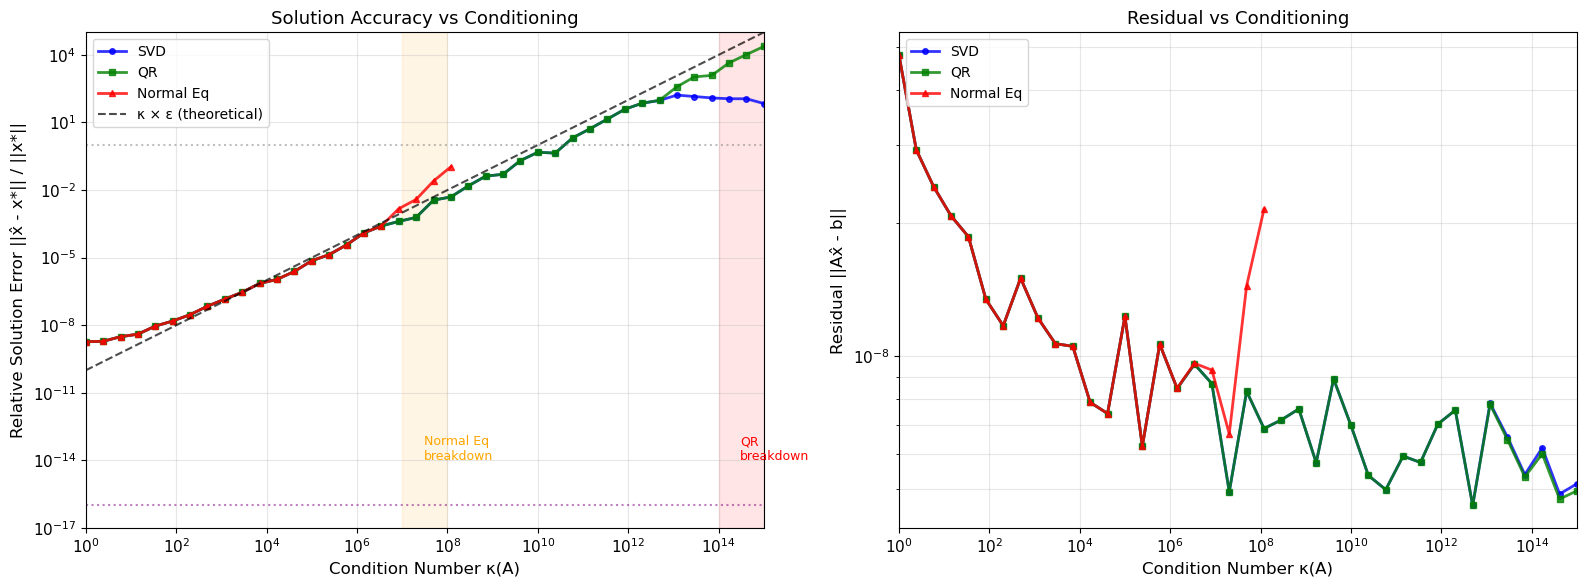


Key Observations:
  1. SVD is most robust across all condition numbers
  2. QR matches SVD until very high κ (> 10¹²)
  3. Normal Equations break down around κ ≈ 10⁸ (since κ² = 10¹⁶)


In [13]:
# ============================================================
# EXERCISE 8.2: Visualize Solver Comparison
# ============================================================

print("="*70)
print("Exercise 8.2: Solver Comparison Visualization")
print("="*70)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Solution Error
ax1 = axes[0]
ax1.loglog(results['kappa'], results['svd_error'], 'b-', linewidth=2, 
           marker='o', markersize=4, label='SVD', alpha=0.8)
ax1.loglog(results['kappa'], results['qr_error'], 'g-', linewidth=2,
           marker='s', markersize=4, label='QR', alpha=0.8)
ax1.loglog(results['kappa'], results['normal_error'], 'r-', linewidth=2,
           marker='^', markersize=4, label='Normal Eq', alpha=0.8)

# Reference lines
ax1.loglog(results['kappa'], np.array(results['kappa']) * noise_level, 'k--', 
           linewidth=1.5, alpha=0.7, label='κ × ε (theoretical)')
ax1.axhline(1.0, color='gray', linestyle=':', alpha=0.5)
ax1.axhline(1e-16, color='purple', linestyle=':', alpha=0.5)

ax1.set_xlabel('Condition Number κ(A)', fontsize=12)
ax1.set_ylabel('Relative Solution Error ||x̂ - x*|| / ||x*||', fontsize=12)
ax1.set_title('Solution Accuracy vs Conditioning', fontsize=13)
ax1.legend(fontsize=10, loc='upper left')
ax1.grid(True, which='both', alpha=0.3)
ax1.set_xlim(1, 1e15)
ax1.set_ylim(1e-17, 1e5)

# Annotate breakdown regions
ax1.axvspan(1e7, 1e8, alpha=0.1, color='orange', label='Normal Eq breaks')
ax1.axvspan(1e14, 1e15, alpha=0.1, color='red')
ax1.text(3e7, 1e-14, 'Normal Eq\nbreakdown', fontsize=9, color='orange')
ax1.text(3e14, 1e-14, 'QR\nbreakdown', fontsize=9, color='red')

# Plot 2: Residual
ax2 = axes[1]
ax2.loglog(results['kappa'], results['svd_residual'], 'b-', linewidth=2,
           marker='o', markersize=4, label='SVD', alpha=0.8)
ax2.loglog(results['kappa'], results['qr_residual'], 'g-', linewidth=2,
           marker='s', markersize=4, label='QR', alpha=0.8)
ax2.loglog(results['kappa'], results['normal_residual'], 'r-', linewidth=2,
           marker='^', markersize=4, label='Normal Eq', alpha=0.8)

ax2.set_xlabel('Condition Number κ(A)', fontsize=12)
ax2.set_ylabel('Residual ||Ax̂ - b||', fontsize=12)
ax2.set_title('Residual vs Conditioning', fontsize=13)
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(True, which='both', alpha=0.3)
ax2.set_xlim(1, 1e15)

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  1. SVD is most robust across all condition numbers")
print("  2. QR matches SVD until very high κ (> 10¹²)")
print("  3. Normal Equations break down around κ ≈ 10⁸ (since κ² = 10¹⁶)")

In [14]:
# ============================================================
# EXERCISE 8.3: Summary Table at Key Condition Numbers
# ============================================================

print("="*70)
print("Exercise 8.3: Solver Performance Summary")
print("="*70)

# Find indices for specific condition numbers
target_kappas = [1e0, 1e4, 1e8, 1e12, 1e15]
print(f"\n{'κ(A)':>12} | {'SVD Error':>12} | {'QR Error':>12} | {'Normal Error':>14}")
print("-" * 60)

for target in target_kappas:
    idx = np.argmin(np.abs(np.array(results['kappa']) - target))
    k = results['kappa'][idx]
    svd_e = results['svd_error'][idx]
    qr_e = results['qr_error'][idx]
    norm_e = results['normal_error'][idx]
    
    def fmt(x):
        if np.isnan(x):
            return "FAILED"
        elif x > 1:
            return f"{x:.2e} ⚠️"
        else:
            return f"{x:.2e}"
    
    print(f"{k:>12.0e} | {fmt(svd_e):>12} | {fmt(qr_e):>12} | {fmt(norm_e):>14}")

print("-" * 60)
print("\n⚠️  = Error > 100% (solution is meaningless)")
print("FAILED = Solver crashed (Cholesky failed, singular matrix)")

print("\n" + "="*70)
print("CONCLUSIONS:")
print("="*70)
print("""
1. NORMAL EQUATIONS (κ < 10⁶-10⁸):
   - Fastest for well-conditioned problems
   - Breaks down when κ(A)² exceeds float64 precision (~10¹⁶)
   
2. QR FACTORIZATION (κ < 10¹²-10¹⁴):
   - Good middle ground: fast and reasonably stable
   - Works until κ(A) itself approaches float64 limits
   
3. SVD (any κ):
   - Most robust method
   - Handles rank-deficient and severely ill-conditioned cases
   - Slowest, but provides additional diagnostic info
""")

Exercise 8.3: Solver Performance Summary

        κ(A) |    SVD Error |     QR Error |   Normal Error
------------------------------------------------------------
       1e+00 |     1.86e-09 |     1.86e-09 |       1.86e-09
       7e+03 |     7.16e-07 |     7.16e-07 |       7.16e-07
       1e+08 |     4.95e-03 |     4.95e-03 |       1.08e-01
       8e+11 |  3.85e+01 ⚠️ |  3.85e+01 ⚠️ |         FAILED
       1e+15 |  6.92e+01 ⚠️ |  2.36e+04 ⚠️ |         FAILED
------------------------------------------------------------

⚠️  = Error > 100% (solution is meaningless)
FAILED = Solver crashed (Cholesky failed, singular matrix)

CONCLUSIONS:

1. NORMAL EQUATIONS (κ < 10⁶-10⁸):
   - Fastest for well-conditioned problems
   - Breaks down when κ(A)² exceeds float64 precision (~10¹⁶)

2. QR FACTORIZATION (κ < 10¹²-10¹⁴):
   - Good middle ground: fast and reasonably stable
   - Works until κ(A) itself approaches float64 limits

3. SVD (any κ):
   - Most robust method
   - Handles rank-deficient an

---

## 9. Practical ML Context

### 9.1 Linear Regression & Multicollinearity

In regression with design matrix $X \in \mathbb{R}^{n \times p}$:

$$\hat{\beta} = (X^T X)^{-1} X^T y$$

**Multicollinearity** = high correlation between features → large $\kappa(X)$.

**Symptoms:**
- Small changes in data → huge changes in $\hat{\beta}$
- Coefficients have unexpected signs/magnitudes
- Standard errors on coefficients are very large

**Solutions:**
1. **Ridge Regression:** Add regularization: $(X^T X + \lambda I)^{-1} X^T y$
   - Effectively adds $\lambda$ to all eigenvalues
   - Reduces condition number to $\frac{\sigma_1^2 + \lambda}{\sigma_n^2 + \lambda}$
   
2. **PCA/Feature Selection:** Remove correlated features

3. **Use SVD solver:** At minimum, don't use normal equations

---

### 9.2 Optimization Context

**Gradient Descent on Quadratic:**
$$f(x) = \frac{1}{2} x^T A x - b^T x$$

Gradient: $\nabla f = Ax - b$

Optimal step size: $\alpha^* = \frac{r^T r}{r^T A r}$

**Convergence rate:**
$$\|x_{k+1} - x^*\| \leq \left(\frac{\kappa - 1}{\kappa + 1}\right) \|x_k - x^*\|$$

**Impact:**
| $\kappa(A)$ | Iterations to halve error |
|-------------|--------------------------|
| 1 | 0.7 |
| 10 | 2.4 |
| 100 | 4.6 |
| 1000 | 6.9 |
| 10000 | 9.2 |

**High conditioning → slow convergence → need preconditioning!**

---

### 9.3 When to Worry

| Signal | Action |
|--------|--------|
| $\kappa(X) > 30$ | Consider: Is multicollinearity real or spurious? |
| $\kappa(X) > 10^3$ | Strongly consider regularization |
| $\kappa(X) > 10^6$ | Use QR or SVD solver, definitely regularize |
| $\kappa(X) > 10^{12}$ | Problem is essentially rank-deficient, need reformulation |

Exercise 9.1: Ridge Regression Improves Conditioning
Design matrix X: (200, 50)
Condition number κ(X): 2.74e+02
Condition number κ(XᵀX): 7.50e+04

OLS relative error: 1.2259


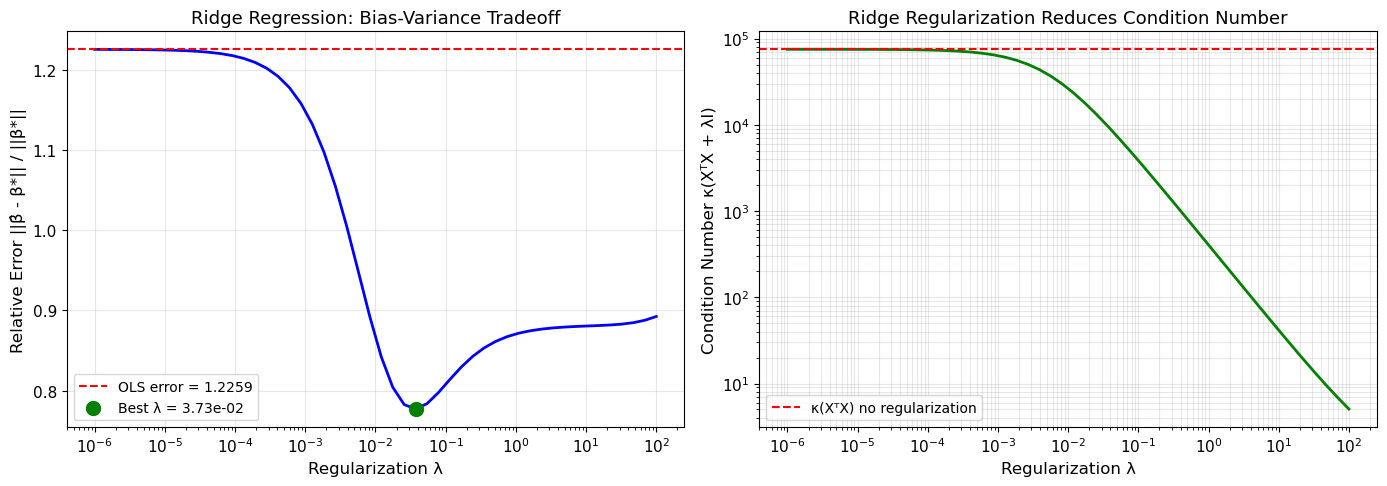


Best ridge λ = 3.73e-02 gives error = 0.7770
This reduces κ(XᵀX + λI) from 7.50e+04 to 9.51e+03


In [15]:
# ============================================================
# EXERCISE 9.1: Ridge Regression Improves Conditioning
# ============================================================

print("="*70)
print("Exercise 9.1: Ridge Regression Improves Conditioning")
print("="*70)

np.random.seed(42)

# Create ill-conditioned design matrix (multicollinear features)
n, p = 200, 50
X_base = np.random.randn(n, 10)
# Create correlated features
X = np.column_stack([X_base] + [X_base @ np.random.randn(10, 10) * 0.1 + np.random.randn(n, 10) * 0.01 for _ in range(4)])

print(f"Design matrix X: {X.shape}")
print(f"Condition number κ(X): {np.linalg.cond(X):.2e}")
print(f"Condition number κ(XᵀX): {np.linalg.cond(X.T @ X):.2e}")

# True coefficients and response
beta_true = np.random.randn(p)
y = X @ beta_true + 0.1 * np.random.randn(n)

# Try OLS
try:
    beta_ols = np.linalg.solve(X.T @ X, X.T @ y)
    ols_error = np.linalg.norm(beta_ols - beta_true) / np.linalg.norm(beta_true)
    print(f"\nOLS relative error: {ols_error:.4f}")
except:
    print("\nOLS: Cholesky failed!")

# Ridge regression for various λ
lambdas = np.logspace(-6, 2, 50)
ridge_errors = []
condition_numbers = []

for lam in lambdas:
    XTX_ridge = X.T @ X + lam * np.eye(p)
    beta_ridge = np.linalg.solve(XTX_ridge, X.T @ y)
    
    ridge_errors.append(np.linalg.norm(beta_ridge - beta_true) / np.linalg.norm(beta_true))
    condition_numbers.append(np.linalg.cond(XTX_ridge))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Error vs λ
ax1 = axes[0]
ax1.semilogx(lambdas, ridge_errors, 'b-', linewidth=2)
ax1.axhline(ols_error, color='r', linestyle='--', label=f'OLS error = {ols_error:.4f}')
best_idx = np.argmin(ridge_errors)
ax1.scatter([lambdas[best_idx]], [ridge_errors[best_idx]], color='green', s=100, 
            zorder=5, label=f'Best λ = {lambdas[best_idx]:.2e}')
ax1.set_xlabel('Regularization λ', fontsize=12)
ax1.set_ylabel('Relative Error ||β̂ - β*|| / ||β*||', fontsize=12)
ax1.set_title('Ridge Regression: Bias-Variance Tradeoff', fontsize=13)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Condition number vs λ
ax2 = axes[1]
ax2.loglog(lambdas, condition_numbers, 'g-', linewidth=2)
ax2.axhline(np.linalg.cond(X.T @ X), color='r', linestyle='--', label='κ(XᵀX) no regularization')
ax2.set_xlabel('Regularization λ', fontsize=12)
ax2.set_ylabel('Condition Number κ(XᵀX + λI)', fontsize=12)
ax2.set_title('Ridge Regularization Reduces Condition Number', fontsize=13)
ax2.legend(fontsize=10)
ax2.grid(True, which='both', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nBest ridge λ = {lambdas[best_idx]:.2e} gives error = {ridge_errors[best_idx]:.4f}")
print(f"This reduces κ(XᵀX + λI) from {np.linalg.cond(X.T @ X):.2e} to {condition_numbers[best_idx]:.2e}")

---

## 10. Algorithm Decision Flowchart

### 10.1 Choosing a Least-Squares Solver

```
┌─────────────────────────────────────┐
│ Need to solve min_x ||Ax - b||²    │
└──────────────────┬──────────────────┘
                   │
                   ▼
         ┌─────────────────────┐
         │ Is A rank-deficient │
         │ or nearly so?       │
         └──────────┬──────────┘
                    │
         ┌──────────┴──────────┐
         │ YES                 │ NO
         ▼                     ▼
   ┌───────────┐      ┌─────────────────┐
   │  Use SVD  │      │ What is κ(A)?   │
   │  (pinv)   │      └────────┬────────┘
   └───────────┘               │
                    ┌──────────┴──────────┐
                    │                     │
              κ < 10⁶               κ > 10⁶
                    │                     │
                    ▼                     ▼
           ┌──────────────┐      ┌──────────────┐
           │ Normal Eq    │      │ Is κ < 10¹²? │
           │ (fastest)    │      └──────┬───────┘
           └──────────────┘             │
                              ┌─────────┴─────────┐
                              │ YES               │ NO
                              ▼                   ▼
                       ┌───────────┐       ┌───────────┐
                       │ QR factor │       │ Use SVD   │
                       │ (stable)  │       │ or reform │
                       └───────────┘       └───────────┘
```

---

### 10.2 Quick Reference Card

| Situation | Recommended Method | Why |
|-----------|-------------------|-----|
| Well-conditioned, need speed | Normal Equations + Cholesky | $O(n^3/3)$ |
| Moderate conditioning, full rank | QR Factorization | Stable, fast |
| Ill-conditioned, full rank | QR or SVD | Avoid κ² |
| Rank-deficient | SVD | Handles rank drop |
| Need minimum-norm solution | SVD (pseudoinverse) | Theoretical guarantee |
| Regularized (Ridge) | Normal Equations | λ improves conditioning |
| Sparse system | Iterative methods | Not covered here |

---

### 10.3 NumPy/SciPy Reference

```python
# Normal equations (don't form AᵀA explicitly in practice!)
x = np.linalg.solve(A.T @ A, A.T @ b)

# QR factorization
x, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

# SVD/Pseudoinverse  
x = np.linalg.pinv(A) @ b

# Or equivalently:
U, s, Vt = np.linalg.svd(A, full_matrices=False)
x = Vt.T @ (np.where(s > tol, 1/s, 0) * (U.T @ b))

# Ridge regression
x = np.linalg.solve(A.T @ A + lambda_ * np.eye(n), A.T @ b)

# SciPy alternatives (often better)
from scipy.linalg import lstsq, solve, cho_solve, cho_factor, qr
```

In [16]:
# ============================================================
# EXERCISE 10.1: Decision Flowchart in Action
# ============================================================

def recommend_solver(A, verbose=True):
    """
    Recommend a least-squares solver based on matrix properties.
    
    Returns: (recommendation, reason)
    """
    m, n = A.shape
    rank = np.linalg.matrix_rank(A)
    kappa = np.linalg.cond(A)
    
    if verbose:
        print(f"Matrix analysis: {m}×{n}, rank={rank}, κ={kappa:.2e}")
    
    # Check rank deficiency
    if rank < min(m, n):
        return "SVD (pinv)", f"Rank-deficient: rank={rank} < min(m,n)={min(m,n)}"
    
    # Check conditioning
    if kappa < 1e6:
        return "Normal Equations", f"Well-conditioned: κ={kappa:.2e} < 10⁶"
    elif kappa < 1e12:
        return "QR Factorization", f"Moderate conditioning: 10⁶ < κ={kappa:.2e} < 10¹²"
    else:
        return "SVD", f"Ill-conditioned: κ={kappa:.2e} > 10¹²"

print("="*70)
print("Exercise 10.1: Automatic Solver Selection")
print("="*70)

np.random.seed(42)

# Test cases
test_cases = [
    ("Random well-conditioned", np.random.randn(100, 20)),
    ("Ill-conditioned (κ=10⁸)", create_matrix_with_condition(100, 20, 1e8)),
    ("Rank-deficient", np.random.randn(100, 5) @ np.random.randn(5, 20)),
    ("Very ill-conditioned (κ=10¹⁴)", create_matrix_with_condition(100, 20, 1e14)),
]

print("\nSolver Recommendations:")
print("-" * 70)
for name, A in test_cases:
    print(f"\n{name}:")
    method, reason = recommend_solver(A)
    print(f"  → Recommended: {method}")
    print(f"     Reason: {reason}")

Exercise 10.1: Automatic Solver Selection

Solver Recommendations:
----------------------------------------------------------------------

Random well-conditioned:
Matrix analysis: 100×20, rank=20, κ=2.51e+00
  → Recommended: Normal Equations
     Reason: Well-conditioned: κ=2.51e+00 < 10⁶

Ill-conditioned (κ=10⁸):
Matrix analysis: 100×20, rank=20, κ=1.00e+08
  → Recommended: QR Factorization
     Reason: Moderate conditioning: 10⁶ < κ=1.00e+08 < 10¹²

Rank-deficient:
Matrix analysis: 100×20, rank=5, κ=7.86e+16
  → Recommended: SVD (pinv)
     Reason: Rank-deficient: rank=5 < min(m,n)=20

Very ill-conditioned (κ=10¹⁴):
Matrix analysis: 100×20, rank=19, κ=1.00e+14
  → Recommended: SVD (pinv)
     Reason: Rank-deficient: rank=19 < min(m,n)=20


---

## 11. Summary & Key Takeaways

### 11.1 Core Concepts Mastered

#### A. The Least-Squares Problem
$$\min_x \|Ax - b\|_2^2$$
- **Geometric View:** Find $x$ such that $Ax$ is the projection of $b$ onto $\text{Col}(A)$
- **Algebraic View:** Solve $A^T(Ax - b) = 0$ (normal equations)
- **SVD View:** $\hat{x} = A^+ b$ where $A^+ = V\Sigma^+ U^T$

#### B. The Moore-Penrose Pseudoinverse
- **Definition:** $A^+ = V\Sigma^+ U^T$ from SVD
- **Key Properties:**
  1. $AA^+A = A$ (generalized inverse)
  2. $A^+AA^+ = A^+$ (reflexive)
  3. $(AA^+)^T = AA^+$ (orthogonal projector onto $\text{Col}(A)$)
  4. $(A^+A)^T = A^+A$ (orthogonal projector onto $\text{Row}(A)$)
- **Minimum-Norm:** Among all least-squares solutions, $x = A^+ b$ has smallest $\|x\|_2$

#### C. Condition Number & Sensitivity
- **Definition:** $\kappa(A) = \sigma_{\max}/\sigma_{\min}$
- **Meaning:** Amplification factor for input perturbations → output errors
- **Rule:** Relative error in solution $\approx \kappa(A) \times$ relative error in data

#### D. Three Solvers Compared

| Method | Effective κ | When to Use | When to Avoid |
|--------|-------------|-------------|---------------|
| **Normal Equations** | $\kappa^2$ | κ < 10⁶, need speed | Ill-conditioned |
| **QR Factorization** | $\kappa$ | Full rank, moderate κ | Rank-deficient |
| **SVD** | $\kappa$ | Always works | Too slow for huge problems |

---

### 11.2 ML Relevance Summary

| ML Task | Least-Squares Connection |
|---------|-------------------------|
| **Linear Regression** | $\hat{\beta} = (X^TX)^{-1}X^Ty$ or $X^+y$ |
| **Ridge Regression** | $(X^TX + \lambda I)^{-1}X^Ty$ — regularization improves κ |
| **Neural Network Init** | Ill-conditioned layers → vanishing/exploding gradients |
| **PCA** | Condition number of covariance matrix affects stability |
| **Optimization** | Hessian condition number determines convergence rate |

---

### 11.3 Mastery Checklist

**Theory:**
- [ ] I can derive the normal equations from calculus
- [ ] I can explain why $A^+ b$ gives the minimum-norm solution
- [ ] I understand why $\kappa(A^TA) = \kappa(A)^2$ and its consequences
- [ ] I can state the four Moore-Penrose conditions

**Implementation:**
- [ ] I can implement pseudoinverse via SVD from scratch
- [ ] I can implement QR-based least-squares solver
- [ ] I can implement normal equations solver (with Cholesky)
- [ ] I know when each solver will fail/succeed

**Application:**
- [ ] I can diagnose multicollinearity from condition number
- [ ] I know when to use regularization
- [ ] I can explain slow gradient descent via conditioning
- [ ] I can select the appropriate solver for a given problem

In [17]:
# ============================================================
# FINAL VERIFICATION: Run All Key Concepts
# ============================================================

print("="*70)
print("FINAL VERIFICATION: Block 4 Complete")
print("="*70)

np.random.seed(42)

# Quick verification of all main concepts
print("\n[1] Moore-Penrose Pseudoinverse")
A = np.random.randn(5, 3)
A_pinv = np.linalg.pinv(A)
conditions = [
    np.allclose(A @ A_pinv @ A, A),
    np.allclose(A_pinv @ A @ A_pinv, A_pinv),
    np.allclose((A @ A_pinv).T, A @ A_pinv),
    np.allclose((A_pinv @ A).T, A_pinv @ A)
]
print(f"    All 4 Moore-Penrose conditions: {'✓' if all(conditions) else '✗'}")

print("\n[2] Condition Number Squaring")
kappa_A = np.linalg.cond(A)
kappa_ATA = np.linalg.cond(A.T @ A)
print(f"    κ(A) = {kappa_A:.2f}, κ(AᵀA) = {kappa_ATA:.2f}")
print(f"    κ(AᵀA) ≈ κ(A)²: {'✓' if np.isclose(kappa_ATA, kappa_A**2, rtol=0.1) else '✗'}")

print("\n[3] Three Solvers Agreement (well-conditioned)")
m, n = 50, 10
A = np.random.randn(m, n)
b = np.random.randn(m)
x_svd = solve_lstsq_svd(A, b)
x_normal = solve_lstsq_normal(A, b)
x_qr = solve_lstsq_qr(A, b)
agree = np.allclose(x_svd, x_normal) and np.allclose(x_svd, x_qr)
print(f"    All three solvers agree: {'✓' if agree else '✗'}")

print("\n[4] Minimum-Norm Property")
A_wide = np.random.randn(3, 6)
b = np.random.randn(3)
x_pinv = np.linalg.pinv(A_wide) @ b
# Any other solution
_, s, Vt = np.linalg.svd(A_wide, full_matrices=True)
null_basis = Vt[np.sum(s > 1e-10):].T
x_other = x_pinv + null_basis @ np.random.randn(null_basis.shape[1])
is_min_norm = np.linalg.norm(x_pinv) <= np.linalg.norm(x_other) + 1e-10
print(f"    x⁺ has minimum norm: {'✓' if is_min_norm else '✗'}")

print("\n[5] Error Amplification")
A_ill = create_matrix_with_condition(50, 20, 1e8)
x_true = np.random.randn(20)
b_exact = A_ill @ x_true
noise = 1e-10 * np.linalg.norm(b_exact) * np.random.randn(50)
x_computed = np.linalg.lstsq(A_ill, b_exact + noise, rcond=None)[0]
rel_err = np.linalg.norm(x_computed - x_true) / np.linalg.norm(x_true)
expected = 1e8 * 1e-10  # κ × noise
amplified = rel_err > 1e-10  # Error larger than input noise
print(f"    κ ≈ 10⁸, noise = 10⁻¹⁰ → error ≈ {rel_err:.2e}")
print(f"    Error amplified by κ: {'✓' if amplified else '✗'}")

print("\n" + "="*70)
print("✓ ALL CONCEPTS VERIFIED")
print("="*70)
print("""
BLOCK 4 COMPLETE: Pseudoinverse, Least-Squares & Conditioning

You have mastered:
• Moore-Penrose pseudoinverse from SVD
• Condition number and sensitivity analysis  
• Three least-squares solvers with tradeoffs
• When and why normal equations fail
• Practical implications for ML/regression
""")

FINAL VERIFICATION: Block 4 Complete

[1] Moore-Penrose Pseudoinverse
    All 4 Moore-Penrose conditions: ✓

[2] Condition Number Squaring
    κ(A) = 3.12, κ(AᵀA) = 9.75
    κ(AᵀA) ≈ κ(A)²: ✓

[3] Three Solvers Agreement (well-conditioned)
    All three solvers agree: ✓

[4] Minimum-Norm Property
    x⁺ has minimum norm: ✓

[5] Error Amplification
    κ ≈ 10⁸, noise = 10⁻¹⁰ → error ≈ 1.40e-03
    Error amplified by κ: ✓

✓ ALL CONCEPTS VERIFIED

BLOCK 4 COMPLETE: Pseudoinverse, Least-Squares & Conditioning

You have mastered:
• Moore-Penrose pseudoinverse from SVD
• Condition number and sensitivity analysis  
• Three least-squares solvers with tradeoffs
• When and why normal equations fail
• Practical implications for ML/regression

